# Otto商品分类——RBF 核SVM

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，分别用缺省参数SVC和SVC进行参数调优后的模型对Otto数据进行商品分类。

Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data


In [18]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

#竞赛的评价指标为logloss
#from sklearn.metrics import log_loss  

#SVM虽然也支持输出各类的概率，但这需要额外的计算费用，且得到的概率也不保证是合法的概率，
#所以在这个例子中我们用正确率accuracy_score作为模型选择的度量，最后在最佳超参数情况下再训练模型，得到概率表示
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt

#显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

## 读取数据 

In [19]:
# 读取数据
# path to where the data lies
dpath = './data/'

#原始特征 + tf_idf特征对线性SVM训练还是很快，RBF核已慢得不行
# RBF核只用tf_idf特征
train = pd.read_csv(dpath +"Otto_FE_train_tfidf.csv")
train.head()

,id,feat_1_tfidf,feat_2_tfidf,feat_3_tfidf,feat_4_tfidf,feat_5_tfidf,feat_6_tfidf,feat_7_tfidf,feat_8_tfidf,feat_9_tfidf,...,feat_85_tfidf,feat_86_tfidf,feat_87_tfidf,feat_88_tfidf,feat_89_tfidf,feat_90_tfidf,feat_91_tfidf,feat_92_tfidf,feat_93_tfidf,target
0,1,0.081393,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.075886,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
1,2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.231403,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
2,3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.199730,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
3,4,0.011987,0.0,0.0,0.011668,0.105971,0.021681,0.080435,0.000000,0.0,...,0.000000,0.008244,0.022456,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
4,5,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.124622,0.000000,0.000000,0.0,0.0,0.145988,0.0,0.0,0.0,Class_1


In [3]:
#train.info()

## 准备数据

In [20]:
# 将类别字符串变成数字
# drop ids and get labels
y_train = train['target']   #形式为Class_x
X_train = train.drop(["id", "target"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

In [23]:
# 训练样本6w+，交叉验证太慢，用train_test_split估计模型性能
# SVM对大样本数据集支持不太好
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.8,random_state = 0)

In [24]:
print (X_train_part.shape)

(49502, 93)


## 模型训练

### RBF核SVM正则参数调优

RBF核是SVM最常用的核函数。
RBF核SVM 的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和核函数的宽度gamma
C越小，决策边界越平滑； 
gamma越小，决策边界越平滑。

采用交叉验证，网格搜索步骤与Logistic回归正则参数处理类似，在此略。

这里我们用校验集（X_val、y_val）来估计模型性能

In [25]:
from sklearn.svm import SVC

In [26]:
def fit_grid_point_RBF(C, gamma, X_train, y_train, X_val, y_val):
    
    # 在训练集是那个利用SVC训练
    SVC3 =  SVC( C = C, kernel='rbf', gamma = gamma)
    SVC3 = SVC3.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC3.score(X_val, y_val)
    
    print("C= {} and gamma = {}: accuracy= {} " .format(C, gamma, accuracy))
    return accuracy

C= 0.1 and gamma = 0.01: accuracy= 0.697963800905 
C= 10.0 and gamma = 0.01: accuracy= 0.758080155139 
C= 100.0 and gamma = 0.01: accuracy= 0.770685197156 
C= 1000.0 and gamma = 0.01: accuracy= 0.786522301228 
C= 10000.0 and gamma = 0.01: accuracy= 0.805106658048 
C= 100000.0 and gamma = 0.01: accuracy= 0.799773755656
C= 10000.0 and gamma = 0.1: accuracy= 0.790804783452

In [34]:
gamma = 0.1
C_s = np.logspace( 4, 6) 
accuracy_s = np.zeros(len(C_s))
for j, C in enumerate(C_s):
    accuracy_s[0,j] = fit_grid_point_RBF(C, gamma, X_train_part, y_train_part, X_val, y_val)

C= 10000.0 and gamma = 0.1: accuracy= 0.790804783452 


IndexError: too many indices for array

In [15]:
accuracy_s = np.matrix(np.zeros(shape=(5, 3)), float)
gamma_s = np.logspace(-1, 1, 3)  

In [10]:
oneC = 0.1

for j, gamma in enumerate(gamma_s):
    accuracy_s[0,j] = fit_grid_point_RBF(oneC, gamma, X_train_part, y_train_part, X_val, y_val)

C= 0.1 and gamma = 0.1: accuracy= 0.738122171946 
C= 0.1 and gamma = 1.0: accuracy= 0.763897866839 
C= 0.1 and gamma = 10.0: accuracy= 0.549208144796 


In [11]:
oneC = 1

for j, gamma in enumerate(gamma_s):
    accuracy_s[1,j] = fit_grid_point_RBF(oneC, gamma, X_train_part, y_train_part, X_val, y_val)

C= 1 and gamma = 0.1: accuracy= 0.761716224952 
C= 1 and gamma = 1.0: accuracy= 0.800985778927 
C= 1 and gamma = 10.0: accuracy= 0.71630575307 


In [12]:
oneC = 10

for j, gamma in enumerate(gamma_s):
    accuracy_s[2,j] = fit_grid_point_RBF(oneC, gamma, X_train_part, y_train_part, X_val, y_val)

C= 10 and gamma = 0.1: accuracy= 0.78603749192 
C= 10 and gamma = 1.0: accuracy= 0.817065287654 
C= 10 and gamma = 10.0: accuracy= 0.727052359405 


In [14]:
oneC = 100

for j, gamma in enumerate(gamma_s):
    accuracy_s[3,j] = fit_grid_point_RBF(oneC, gamma, X_train_part, y_train_part, X_val, y_val)

C= 100 and gamma = 0.1: accuracy= 0.805914673562 
C= 100 and gamma = 1.0: accuracy= 0.807449903038 
C= 100 and gamma = 10.0: accuracy= 0.724951519069 


In [17]:
oneC = 1000

for j, gamma in enumerate(gamma_s):
    accuracy_s[4,j] = fit_grid_point_RBF(oneC, gamma, X_train_part, y_train_part, X_val, y_val)

C= 1000 and gamma = 0.1: accuracy= 0.805914673562 
C= 1000 and gamma = 1.0: accuracy= 0.794521654816 
C= 1000 and gamma = 10.0: accuracy= 0.724062702004 


In [ ]:
#需要调优的参数
#C_s = np.logspace(-1, 3, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
#gamma_s = np.logspace(-1, 1, 3)    

#accuracy_s = []
#for i, oneC in enumerate(C_s):
    #for j, gamma in enumerate(gamma_s):
        #tmp = fit_grid_point_RBF(oneC, gamma, X_train_part, y_train_part, X_val, y_val)
        #accuracy_s[i,j] = tmp

从上述结果会发现，gamma参数非常重要(当gamma=0.01或gamma=100时性能很差),非线性模型比线性模型性能好（注意我们这里只用了tfidf特征）。
但速度慢了不是一点半点(sklearn建议核方法SVM样本数不超过10000)
可以考虑将训练样本分为多个子集，每个子集训练一个RBF核SVM模型，最后多个模型融合的结果的到最终模型（训练速度加快）

C= 0.1 and gamma = 0.1: accuracy= 0.738122171946 
C= 0.1 and gamma = 1.0: accuracy= 0.763897866839 
C= 0.1 and gamma = 10.0: accuracy= 0.549208144796 

C= 1 and gamma = 0.1: accuracy= 0.761716224952 
C= 1 and gamma = 1.0: accuracy= 0.800985778927 
C= 1 and gamma = 10.0: accuracy= 0.71630575307

C= 10 and gamma = 0.1: accuracy= 0.78603749192 
### C= 10 and gamma = 1.0: accuracy= 0.817065287654 
C= 10 and gamma = 10.0: accuracy= 0.727052359405 

C= 100 and gamma = 0.1: accuracy= 0.805914673562 
#### C= 100 and gamma = 1.0: accuracy= 0.807449903038 
C= 100 and gamma = 10.0: accuracy= 0.724951519069

C= 1000 and gamma = 0.1: accuracy= 0.805914673562 
C= 1000 and gamma = 1.0: accuracy= 0.794521654816 
C= 1000 and gamma = 10.0: accuracy= 0.724062702004 

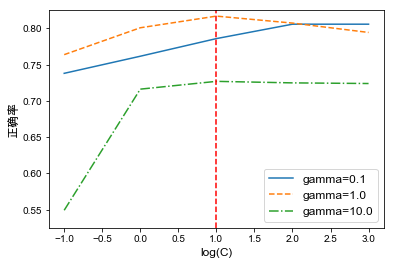

In [35]:
#accuracy_s1 =np.array(accuracy_s).reshape(len(C_s),len(gamma_s))
Otto_SVM_result = pd.read_csv("Otto_SVM_result.csv")
accuracy_s1 = Otto_SVM_result['accuracy']

C_s = np.logspace(-1, 3, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-1, 1, 3)  
accuracy_s1 =np.array(accuracy_s1).reshape(len(C_s),len(gamma_s))

linestyle_list = [ '-', '--', '-.' ]
x_axis = np.log10(C_s)
for j, gamma in enumerate(gamma_s):
    plt.plot(x_axis, np.array(accuracy_s1[:,j]), label = 'gamma=' + str(gamma), ls = linestyle_list[j])

plt.legend(fontsize = 12)
plt.xlabel( 'log(C)' ,fontsize = 12)                                                                                                      
plt.ylabel( u'正确率',fontsize = 12 )

#最佳超参数
plt.axvline(np.log10(10), color='r', ls='--')

plt.ylim(0.525, 0.825)

plt.savefig('RBF_SVM_Otto.png' )

plt.show()

In [23]:
### 最佳超参数
index = np.unravel_index(np.argmax(accuracy_s1, axis=None), accuracy_s1.shape)
Best_C = C_s[ index[0] ]
Best_gamma = gamma_s[ index[1] ]

print(Best_C)
print(Best_gamma)

10.0
1.0


## 找到最佳参数后，用全体训练数据训练模型

In [24]:
# SVC训练SVC，支持概率输出
Best_C = 100
Best_gamma = 1.0

SVC4 =  SVC( C = Best_C, kernel='rbf', gamma = Best_gamma, probability=True)
SVC4.fit(X_train, y_train)

#保持模型，用于后续测试
import cPickle
cPickle.dump(SVC4, open("Otto_RBF_SVC.pkl", 'wb'))